In [56]:
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
!mkdir ./jwData

mkdir: cannot create directory ‘./jwData’: File exists


In [58]:
!aws s3 cp s3://jwismer/alm_report_2016-01-10.csv ./jwData

download: s3://jwismer/alm_report_2016-01-10.csv to jwData/alm_report_2016-01-10.csv


In [59]:
df = pd.read_csv("./jwData/alm_report_2016-01-10.csv")
df.head()

,pid,publication_date,title,citeulike,mendeley,orcid,crossref,datacite,pmceurope,pmceuropedata,...,figshare,pmc,relativemetric,f1000,mendeley_readers,mendeley_groups,pmc_html,pmc_pdf,counter_html,counter_pdf
0,http://doi.org/10.1371/journal.pbio.0000005,2003-08-18,The Transcriptome of the Intraerythrocytic Dev...,0,385,0,0,0,525,0,...,0,8005,2723698,3,372,13,5203,2802,40140,5702
1,http://doi.org/10.1371/journal.pbio.0000011,2003-08-18,Monitoring Malaria: Genomic Activity of the Pa...,0,3,0,0,0,0,0,...,0,1201,872174,0,3,0,910,291,5507,255
2,http://doi.org/10.1371/journal.pbio.0000006,2003-08-18,DNA Analysis Indicates That Asian Elephants Ar...,0,239,0,0,0,6,31,...,0,4077,1659323,0,231,8,3580,497,22045,2035
3,http://doi.org/10.1371/journal.pbio.0000007,2003-08-18,Borneo Elephants: A High Priority for Conserva...,0,0,0,0,0,0,0,...,0,1140,1833412,0,0,0,890,250,7685,501
4,http://doi.org/10.1371/journal.pbio.0000013,2003-09-15,<i>Drosophila</i> Free-Running Rhythms Require...,0,113,0,0,0,89,5,...,6,2239,1762460,0,108,5,1688,551,12087,1325


In [60]:
df.shape

(184925, 34)

In [61]:
# get pub year for analysis
pub_year = np.array(df.publication_date.str.slice(0, 4))

[['2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012'
  '2013' '2014' '2015' '2016']
 [98 524 1055 1587 2646 4549 6653 9314 16710 27285 37244 40097 36541 622]]


<BarContainer object of 14 artists>

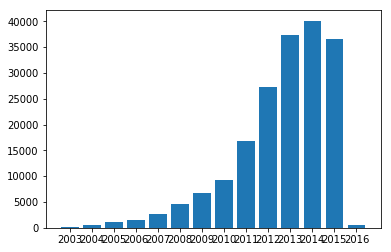

In [62]:
# visualize publications per year
unique_years, counts_years = np.unique(pub_year, return_counts=True)
print(np.asarray((unique_years, counts_years)))
plt.bar(unique_years, counts_years)

In [63]:
from pandas import DataFrame
# sum citation related fields
alm: DataFrame = df.assign(cited=lambda df: (df.scopus + df.crossref + df.pubmed + df.datacite))
print(alm.cited.describe())
# sum view related fields
alm = alm.assign(viewed=lambda df: df.pmceurope + df.counter_html + df.counter_pdf + df.pmc_html + df.pmc_pdf)
print(alm.viewed.describe())
# sum item saved fields
alm = alm.assign(saved=lambda df: df.citeulike + df.mendeley)
print(alm.saved.describe())
# sum social activity related fields
alm = alm.assign(social=lambda df: df.f1000 + df.reddit + df.twitter + df.facebook + df.plos_comments + df.figshare + df.wikipedia)
print(alm.social.describe())

count    184925.000000
mean         10.767879
std          29.188459
min           0.000000
25%           0.000000
50%           3.000000
75%          11.000000
max        3620.000000
Name: cited, dtype: float64
count    1.849250e+05
mean     3.534520e+03
std      7.425073e+03
min      0.000000e+00
25%      1.125000e+03
50%      2.225000e+03
75%      4.047000e+03
max      1.534681e+06
Name: viewed, dtype: float64
count    184925.000000
mean         20.958378
std         160.047696
min           0.000000
25%           3.000000
50%          11.000000
75%          24.000000
max       48103.000000
Name: saved, dtype: float64
count    184925.000000
mean         24.293378
std         357.180198
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max       19993.000000
Name: social, dtype: float64


In [64]:
# tidy up
alm_reduced = alm[['pid', 'cited', 'viewed', 'saved', 'social']].copy()
print(alm_reduced.columns)

Index(['pid', 'cited', 'viewed', 'saved', 'social'], dtype='object')


In [65]:
alm_reduced.isna().sum()

pid       0
cited     0
viewed    0
saved     0
social    0
dtype: int64

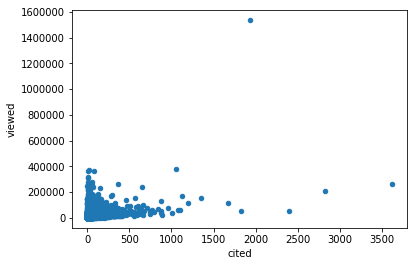

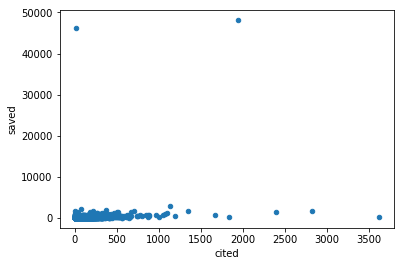

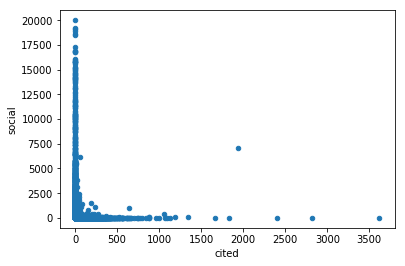

In [66]:
# let's look at some scatter plots for any correlations
alm_reduced.plot.scatter(x='cited', y='viewed')
alm_reduced.plot.scatter(x='cited', y='saved')
alm_reduced.plot.scatter(x='cited', y='social')

In [67]:
# Convert cited to boolean -- this will be the X in the analysis
alm_reduced.cited = alm_reduced.cited.astype('bool')

In [68]:
# split into training and test datasets
from sklearn.model_selection import train_test_split
alm_train, alm_test = train_test_split(alm_reduced,test_size=0.3)
alm_validate, alm_test = train_test_split(alm_test,test_size=0.5)
print(alm_train.shape)
print(alm_validate.shape)
print(alm_test.shape)

(129447, 5)
(27739, 5)
(27739, 5)


In [69]:
# views, saves, social
modelData = np.array(alm_train.loc[:,'viewed':'social']).astype('float32')
# is_cited is target
target = np.array(alm_train['cited']).astype('float32')
#Verify that the conversion worked
print(modelData)
print(target)

[[8.4000e+02 4.0000e+00 0.0000e+00]
 [3.4430e+03 1.1000e+01 0.0000e+00]
 [1.3943e+04 4.3000e+01 8.5000e+01]
 ...
 [4.3000e+01 0.0000e+00 0.0000e+00]
 [4.7680e+03 2.5000e+01 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]
[1. 1. 1. ... 0. 1. 0.]


In [77]:
# test data setup
modelData_validate = np.array(alm_validate.loc[:,'viewed':'social']).astype('float32')
#Verify that the conversion worked
print(modelData_validate)

[[0.000e+00 0.000e+00 0.000e+00]
 [1.404e+03 5.000e+00 0.000e+00]
 [1.843e+03 4.000e+00 0.000e+00]
 ...
 [8.970e+02 5.000e+00 2.000e+00]
 [4.288e+03 1.500e+01 1.000e+00]
 [3.352e+03 0.000e+00 0.000e+00]]


In [71]:
import boto3
import sagemaker
import io
import os
import sagemaker.amazon.common as smac
# Create new sagemaker session
sess = sagemaker.Session()
# S3 bucket to export results to
bucket = "jwismer"
prefix = "ALM/test"
# Use the IO buffer as dataset is small
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, modelData, target)
buf.seek(0)
key = 'linearlearner'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))
# Use multiple regions for ML model
containers = {'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest'}

uploaded training data location: s3://jwismer/ALM/test/train/linearlearner
training artifacts will be uploaded to: s3://jwismer/ALM/test/output


In [72]:
from sagemaker import get_execution_role
role = get_execution_role()
linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)


In [73]:
linear.set_hyperparameters(feature_dim=3,
                           predictor_type='binary_classifier',
                           normalize_data=True)

In [74]:
linear.fit({'train': s3_train_data})
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

2019-05-09 17:15:45 Starting - Starting the training job...
2019-05-09 17:15:48 Starting - Launching requested ML instances......
2019-05-09 17:16:56 Starting - Preparing the instances for training...
2019-05-09 17:17:44 Downloading - Downloading input data...
2019-05-09 17:17:56 Training - Downloading the training image...
2019-05-09 17:18:30 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[05/09/2019 17:18:32 INFO 140071535105856] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4663872077409611, "sum": 0.4663872077409611, "min": 0.4663872077409611}}, "EndTime": 1557422324.549129, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1557422324.549044}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4576048347414002, "sum": 0.4576048347414002, "min": 0.4576048347414002}}, "EndTime": 1557422324.549221, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1557422324.549206}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4693714185611222, "sum": 0.4693714185611222, "min": 0.4693714185611222}}, "EndTime": 1557422324.549267, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learne

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.434772292262824, "sum": 0.434772292262824, "min": 0.434772292262824}}, "EndTime": 1557422332.363125, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1557422332.363042}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4203715633421905, "sum": 0.4203715633421905, "min": 0.4203715633421905}}, "EndTime": 1557422332.363217, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1557422332.363202}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4371113860847414, "sum": 0.4371113860847414, "min": 0.4371113860847414}}, "EndTime": 1557422332.363263, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner",


2019-05-09 17:19:12 Uploading - Uploading generated training model
2019-05-09 17:19:12 Completed - Training job completed
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4178994403218114, "sum": 0.4178994403218114, "min": 0.4178994403218114}}, "EndTime": 1557422340.212748, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1557422340.212688}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.399944669501726, "sum": 0.399944669501726, "min": 0.399944669501726}}, "EndTime": 1557422340.212823, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1557422340.21281}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4198363595415455, "sum": 0.4198363595415455, "min": 0.4198363595415455}}, "EndTime

Billable seconds: 89
---------------------------------------------------------------------------------------!

In [75]:
# Set up
from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [78]:
predictions = []
for array in modelData_validate:
    result = linear_predictor.predict(array)
    predictions += [r['score'] for r in result['predictions']]
predictions = np.array(predictions)
# Push into our pandas dataframe
#alm['Predicted'] = predictions.astype(int))

In [79]:
predictions[0:10]

array([0.2660661 , 0.60538584, 0.64015859, 0.39238665, 0.86609471,
       0.99892151, 0.63084471, 0.2660661 , 1.        , 0.10562352])

In [82]:
alm_validate['cited']

130720    False
130007     True
79613      True
173933    False
39967      True
16985      True
106419     True
117653    False
108355     True
174170    False
122458    False
90913      True
22058      True
153090     True
13278      True
88245      True
157885    False
86443      True
24010      True
23296      True
120000     True
54830      True
160907     True
97988      True
48240      True
33266      True
125864     True
60180      True
173770    False
107253     True
          ...  
128748     True
115944     True
61762      True
106560     True
150163    False
22299      True
19246      True
75143      True
67526      True
100814     True
82551      True
24872      True
93838      True
171056    False
78826      True
108399     True
59803      True
70047      True
13397      True
86767      True
88414     False
55886      True
81289      True
12722      True
126167    False
167665    False
137015    False
161957    False
37126      True
3550      False
Name: cited, Length: 277

In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix(alm_validate['cited'], np.where(predictions >0.5, 1, 0))

array([[ 5391,  2432],
       [ 1031, 18885]])

In [88]:
df_confusion = pd.crosstab(alm_validate['cited'], np.where(predictions >0.5, 1, 0), rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)

Predicted     0      1    All
Actual                       
False      5391   2432   7823
True       1031  18885  19916
All        6422  21317  27739


In [91]:
import sklearn.metrics as sk
sk.accuracy_score(alm_validate['cited'], np.where(predictions >0.5, 1, 0), normalize=True, sample_weight=None)

0.8751577201773676

In [92]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)